In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import time
import json
import scvi
import numpy as np

In [2]:
sc.set_figure_params(figsize=(4, 4))

In [3]:
deep_inject = True
n_epochs_surgery = 300
batch_key = "study"
cell_type_key = "CellType"
target_batches = ["Batch2_10X 5'"]

In [4]:
n_epochs_vae = 500
n_epochs_scanvi = 300
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [5]:
# Save right dir path
if deep_inject:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/figure_7/scanvi/deep_cond/')
else:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_results/figure_7/scanvi/first_cond/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Adata Handling

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/human_pbmc_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
print(adata)
print(adata.obs[batch_key].unique())
print(adata.obs[cell_type_key].unique())

AnnData object with n_obs × n_vars = 15476 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
['Batch1_10X 3'', 'Batch2_10X 5'']
Categories (2, object): ['Batch1_10X 3'', 'Batch2_10X 5'']
['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', 'Monocyte_FCGR3A', 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
Categories (9, object): ['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', ..., 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']


In [7]:
query = np.array([s in target_batches for s in adata.obs.study])
adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [8]:
print(adata_ref)
print(adata_ref.obs[cell_type_key].unique())
print(adata_ref.obs[batch_key].unique())

AnnData object with n_obs × n_vars = 8098 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', 'Monocyte_FCGR3A', 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
Categories (9, object): ['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', ..., 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
['Batch1_10X 3'']
Categories (1, object): ['Batch1_10X 3'']


In [9]:
print(adata_query)
print(adata_query.obs[cell_type_key].unique())
print(adata_query.obs[batch_key].unique())

AnnData object with n_obs × n_vars = 7378 × 4000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'study', 'size_factors'
    uns: 'CellType_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
['NK cell', 'Monocyte_CD14', 'CD8 T cell', 'B cell', 'CD4 T cell', 'Plasmacytoid dendritic cell', 'Monocyte_FCGR3A', 'Megakaryocyte', 'Hematopoietic stem cell']
Categories (9, object): ['NK cell', 'Monocyte_CD14', 'CD8 T cell', 'B cell', ..., 'Plasmacytoid dendritic cell', 'Monocyte_FCGR3A', 'Megakaryocyte', 'Hematopoietic stem cell']
['Batch2_10X 5'']
Categories (1, object): ['Batch2_10X 5'']


In [10]:
scvi.data.setup_anndata(adata_ref, batch_key=batch_key, labels_key=cell_type_key)

INFO      Using batches from adata.obs["study"]                                              
INFO      Using labels from adata.obs["CellType"]                                            
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 8098 cells, 4000 vars, 1 batches,
          9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       
INFO      Please do not further modify adata until model is trained.                         


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# Create SCVI model and train

In [11]:
vae = scvi.model.SCANVI(
    adata_ref,
    "Unknown",
    n_layers=2,
    use_cuda=True,
    encode_covariates=True,
    deeply_inject_covariates=deep_inject,
    use_layer_norm="both",
    use_batch_norm="none",
    use_observed_lib_size=True,
)

In [12]:
print(adata_ref.obs[cell_type_key].unique())
print(adata_ref.obs["_scvi_labels"].unique())
print(adata_ref.obs[batch_key].unique())
print(adata_ref.obs["_scvi_batch"].unique())
print("Labelled Indices: ", vae._labeled_indices.shape[0])
print("Unlabelled Indices: ", vae._unlabeled_indices.shape[0])

['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', 'Monocyte_FCGR3A', 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
Categories (9, object): ['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', ..., 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
[0 1 5 2 6 7 4 8 3]
['Batch1_10X 3'']
Categories (1, object): ['Batch1_10X 3'']
[0]
Labelled Indices:  8098
Unlabelled Indices:  0


In [13]:
ref_time = time.time()
vae.train(
    n_epochs_unsupervised=n_epochs_vae,
    n_epochs_semisupervised=n_epochs_scanvi,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)
ref_time = time.time() - ref_time

INFO      Training Unsupervised Trainer for 500 epochs.                                      
INFO      Training SemiSupervised Trainer for 300 epochs.                                    
INFO      KL warmup for 400 epochs                                                           
Training...:  20%|██        | 102/500 [01:04<04:20,  1.53it/s]INFO                                                                                         
          Stopping early: no improvement of more than 0 nats in 10 epochs                    
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  20%|██        | 102/500 [01:05<04:16,  1.55it/s]
INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  43 

# Reference Evaluation

In [14]:
ref_predictions = vae.predict(adata_ref)
adata_ref.obsm["X_scANVI"] = vae.get_latent_representation()
adata_ref.obs["predictions"] = vae.predict()
print("Acc: {}".format(np.mean(ref_predictions == adata_ref.obs[cell_type_key])))

Acc: 0.9896270684119536


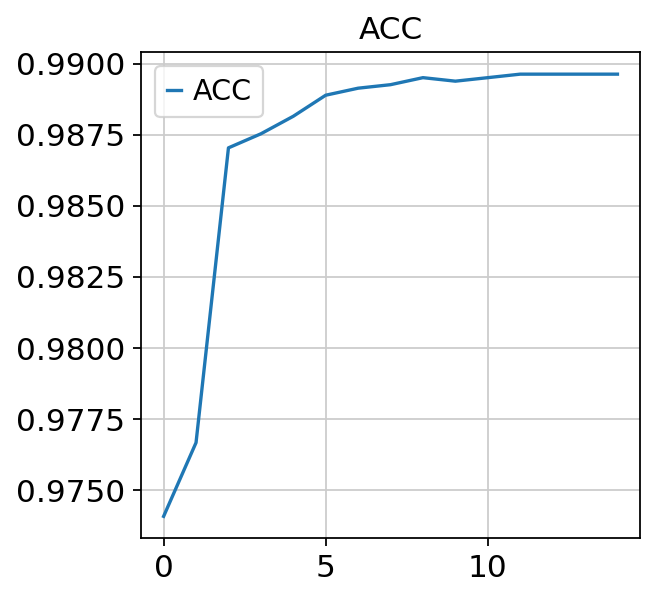

In [15]:
plt.figure()
plt.plot(vae.trainer.history['accuracy_full_dataset'][2:], label="ACC")
plt.title("ACC")
plt.legend()

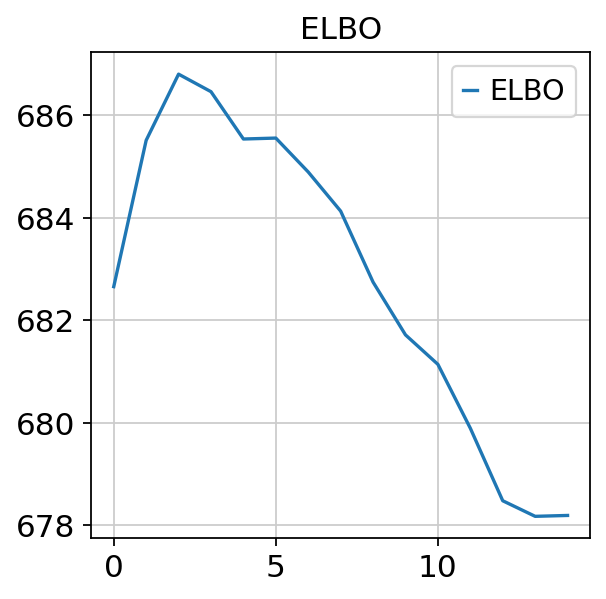

In [16]:
plt.figure()
plt.plot(vae.trainer.history['elbo_full_dataset'][2:], label="ELBO")
plt.title("ELBO")
plt.legend()

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

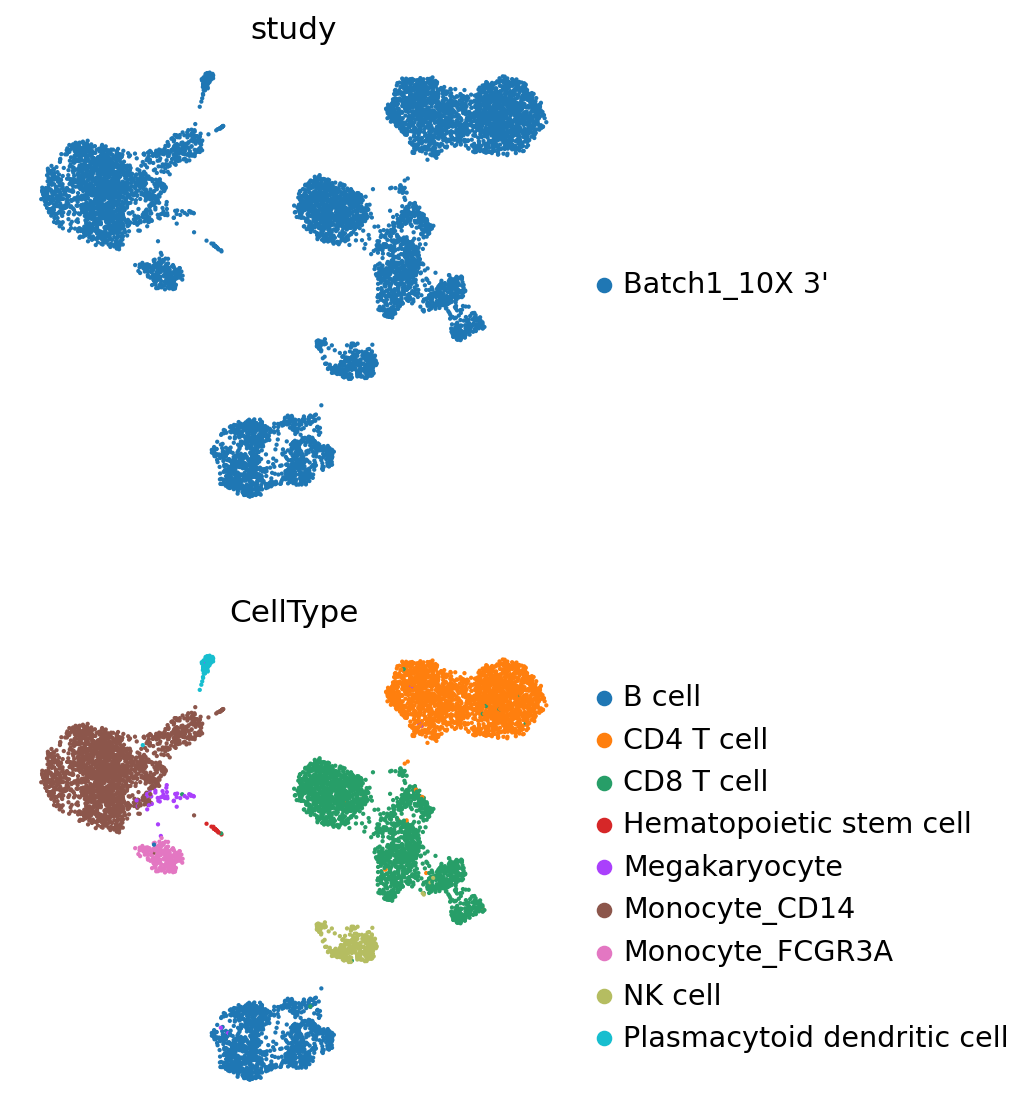

In [17]:
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)
plt.figure()
sc.pl.umap(
    adata_ref,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

In [18]:
adata_ref.write_h5ad(filename=f'{dir_path}reference_data.h5ad')
torch.save(vae.model.state_dict(), f'{dir_path}reference_model_state_dict')
ref_path = f'{dir_path}ref_model/'
if not os.path.exists(ref_path):
    os.makedirs(ref_path)
vae.save(ref_path, overwrite=True)

# Run surgery on query data

In [19]:
model = scvi.model.SCANVI.load_query_data(
    adata_query,
    ref_path,
    use_cuda=True,
    freeze_batchnorm_encoder=True,
    freeze_batchnorm_decoder=True,
    freeze_expression=True,
)

INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']    
INFO      Successfully registered anndata object containing 7378 cells, 4000 vars, 2 batches,
          9 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [20]:
print(adata_query.obs[cell_type_key].unique())
print(adata_query.obs["_scvi_labels"].unique())
print(adata_query.obs[batch_key].unique())
print(adata_query.obs["_scvi_batch"].unique())
model._unlabeled_indices = np.arange(adata_query.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", model._unlabeled_indices.shape[0])

['NK cell', 'Monocyte_CD14', 'CD8 T cell', 'B cell', 'CD4 T cell', 'Plasmacytoid dendritic cell', 'Monocyte_FCGR3A', 'Megakaryocyte', 'Hematopoietic stem cell']
Categories (9, object): ['NK cell', 'Monocyte_CD14', 'CD8 T cell', 'B cell', ..., 'Plasmacytoid dendritic cell', 'Monocyte_FCGR3A', 'Megakaryocyte', 'Hematopoietic stem cell']
[7 5 2 0 1 8 6 4 3]
['Batch2_10X 5'']
Categories (1, object): ['Batch2_10X 5'']
[1]
Labelled Indices:  0
Unlabelled Indices:  7378


In [21]:
query_time = time.time()
model.train(
    n_epochs_semisupervised=n_epochs_surgery,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)
query_time = time.time() - query_time

INFO      Training Unsupervised Trainer for 400 epochs.                                      
INFO      Training SemiSupervised Trainer for 300 epochs.                                    
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           
Training...:  44%|████▎     | 131/300 [04:35<07:47,  2.76s/it]INFO                                                                                         
          Stopping early: no improvement of more than 0.001 nats in 10 epochs                
INFO      If the early stopping criterion is too strong, please instantiate it with different
          parameters in the train method.                                                    
Training...:  44%|████▎     | 131/300 [04:38<05:59,  2.12s/it]
INFO      Training is still i

# Evaluation Surgery on Query1

In [22]:
adata_query.obsm["X_scANVI"] = model.get_latent_representation()
adata_query.obs["predictions"] = model.predict()
query_predictions = model.predict()
print("Acc: {}".format(np.mean(query_predictions == adata_query.obs[cell_type_key])))

Acc: 0.967741935483871


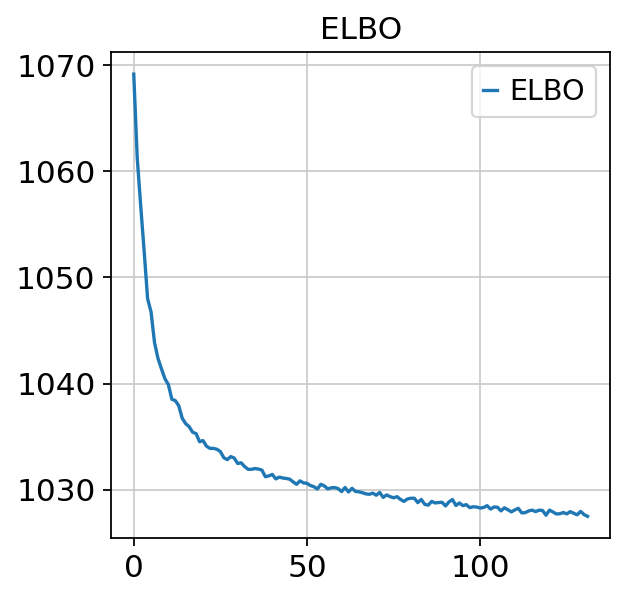

In [23]:
plt.figure()
plt.plot(model.trainer.history['elbo_full_dataset'][2:], label="ELBO")
plt.title("ELBO")
plt.legend()

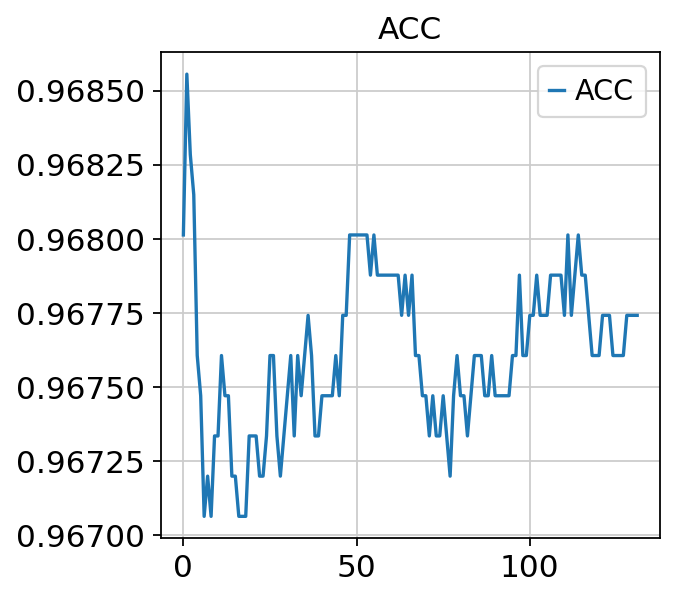

In [24]:
plt.figure()
plt.plot(model.trainer.history['accuracy_full_dataset'][2:], label="ACC")
plt.title("ACC")
plt.legend()

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

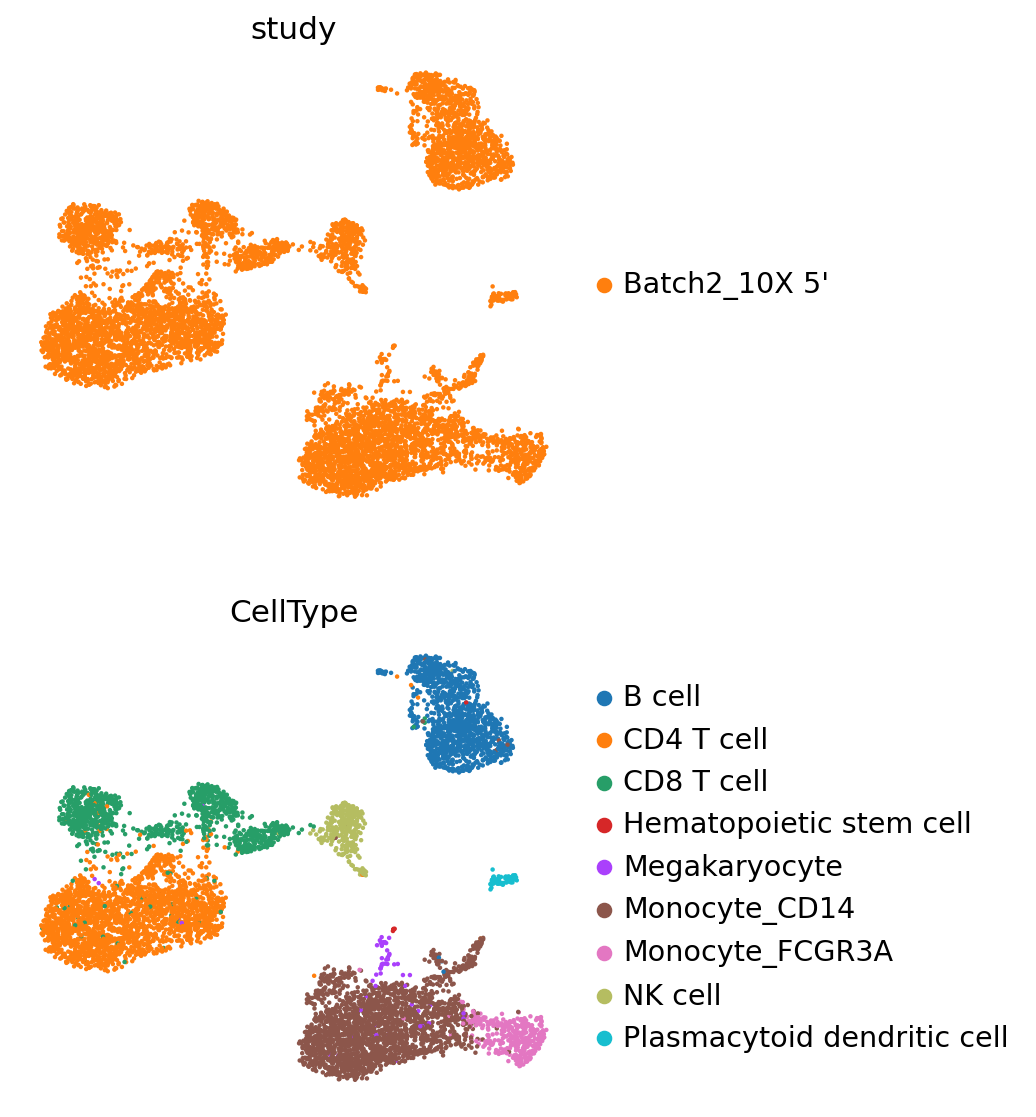

In [25]:
sc.pp.neighbors(adata_query, use_rep="X_scANVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)
plt.figure()
sc.pl.umap(
    adata_query,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

In [26]:
adata_query.write_h5ad(filename=f'{dir_path}query_data.h5ad')

# Evaluation Query on reference

In [27]:
adata_full = adata_ref.concatenate(adata_query)
adata_full.uns["_scvi"] = adata_query.uns["_scvi"]
print(adata_full.obs[cell_type_key].unique())
print(adata_full.obs["_scvi_labels"].unique())
print(adata_full.obs[batch_key].unique())
print(adata_full.obs["_scvi_batch"].unique())
adata_full.obsm["X_scANVI"] = model.get_latent_representation(adata=adata_full)

['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', 'Monocyte_FCGR3A', 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
Categories (9, object): ['B cell', 'CD4 T cell', 'Monocyte_CD14', 'CD8 T cell', ..., 'NK cell', 'Megakaryocyte', 'Plasmacytoid dendritic cell', 'Hematopoietic stem cell']
[0 1 5 2 6 7 4 8 3]
["Batch1_10X 3'" "Batch2_10X 5'"]
[0 1]


In [28]:
full_predictions = model.predict(adata_full)
print("Acc: {}".format(np.mean(full_predictions == adata_full.obs[cell_type_key])))

Acc: 0.9791935900749548


/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Sample' as categorical
... storing 'Method' as categorical
... storing 'study' as categorical


<Figure size 320x320 with 0 Axes>

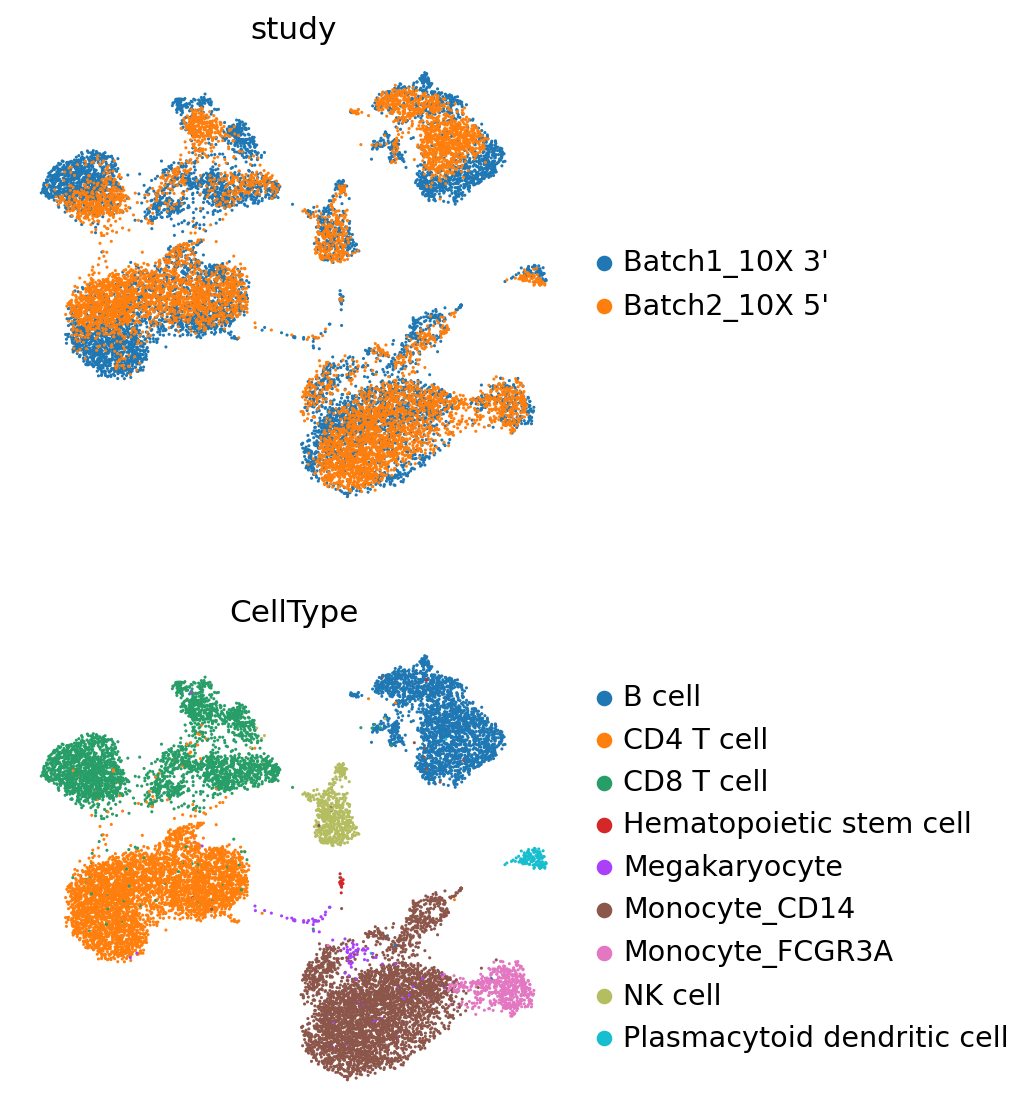

In [29]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)
plt.figure()
sc.pl.umap(
    adata_full,
    color=[batch_key, cell_type_key],
    frameon=False,
    ncols=1,
)

/home/marco/.pyenv/versions/scvi_test/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


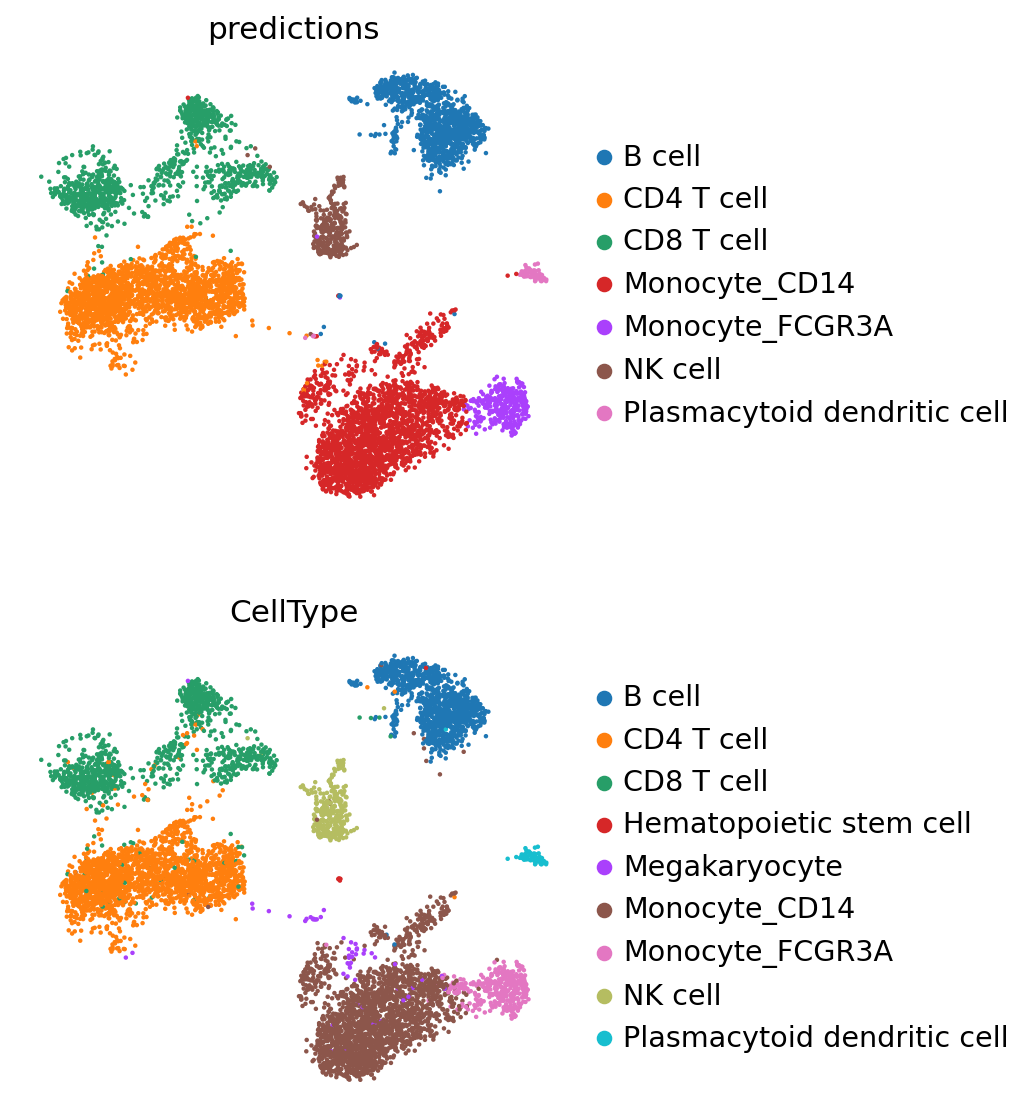

In [30]:
sc.pl.umap(
    adata_full[adata_ref.n_obs:],
    color=["predictions", cell_type_key],
    frameon=False,
    ncols=1,
)

In [31]:
adata_full.write_h5ad(filename=f'{dir_path}full_data.h5ad')
torch.save(model.model.state_dict(), f'{dir_path}surgery_model_state_dict')
surgery_path = f'{dir_path}surg_model/'
if not os.path.exists(surgery_path):
    os.makedirs(surgery_path)
model.save(surgery_path, overwrite=True)

In [32]:
times = dict()
times["ref_time"] = ref_time
times["query_time"] = query_time
times["full_time"] = ref_time + query_time
with open(f'{dir_path}results_times.txt', 'w') as filehandle:
    json.dump(times, filehandle)